In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
""" Necessary modules """
from matplotlib.backends.backend_pdf import PdfPages
from Methods.classify import split_data, plotClass, plotClass_separated, plotClass_separated_ver0
from Methods.miasa_class import Miasa_Class

In [3]:
""" Name and origin of dataset """
DataName = "Correlated_data"
from Methods.simulate_class_data_final import generate_data_correlated

In [4]:
""" Euclidean embedding pameters only used in MIASA (includes a finite number of auto adjustements)
    
    if custom, then type dictionary 
    c_dic = {"c1":float, "c2":float, "c3":float} 
"""
c_dic = "default" 

""" Load or Generate data: 
    
    Required:
    X and Y are separated datasets with M, N samples, respectively, with each samples containing K realizations
    X.shape = (M, K) 
    Y.shape = (N, K)
    num_clust = number of clusters
    dtp : tuple (datatype X_vars , datatype Y_vars) is needed for visualization only
    

    Not Required:
    X_vars, Y_vars = Labels of X and Y samples
    Class_True = True cluster labels of samples
    
"""
palette = "Spectral"# seaborn color palette for true clusters (make sure not to use cyclic color maps)
data_dic_orig, class_dic, num_clust, dtp = generate_data_correlated(var_data = False, palette = palette, 
                                                                   random_state = 46)
X, Y, Class_True, X_vars, Y_vars = split_data(data_dic_orig, class_dic, separation = True) 

In [5]:
"""
Parameters of MIASA, first example
"""
metric_method = ("eCDF", "Spearman_R") # (Similarity, Association) distance models
clust_method = "Agglomerative_ward" # clustering aglorithm to use
palette = "Spectral_r" # seaborn color palette (make sure not to use cyclic color maps)
dist_origin = (True,True) # for datasets (X, Y) decide if the distance to the origin of the axes is interpretable as the norm of the feature representations of the samples
in_threads = False # True to avoid broken runs when using parallel jobs (relevant only for class_experiments.py)

In [6]:
"""
If desired custom similarity feature representation (defining Euclidean similarity distance) 
and association measures then 

1) set 
    metric_method = "precomputed"
2) give Feature_dic as parameter
    Feature_dic["Feature_X"] : array similarity features of dataset X: M samples and L features, X.shape = (M, L)
    Feature_dic["Feature_Y"] : array similarity features of dataset Y: M samples and S features, Y.shape = (N, S)
    Feature_dic["Asssociation_function"] : a function of argument tuple full datasets (X, Y) or pair of samples (X_i, Y_j) computing the pairwise association between the samples of X and Y
    
    Feature_dic["assoc_func_type"] : type of the association function as options
                                    option 1: str vectorized     : argument full datasets (X, Y) => return directly the Asscociation distance matrix of shape (M, N) 
                                    option 2: str not_vectorized : argument samples (X_i, Y_j)   => return a scalar = Associaiton distance between sample X_i and sample Y_j

    Feature_dic["DMat"]  : array distance function, then Feature_dic["Asssociation_function"] Feature_dic["assoc_func_type"] can be set to None 
    Feature_dic["dist_origin"]: bool tuple (X?, Y?) deciding if the distance to the origin of the axes is interpretable as the norm of the feature representations of the samples
                                Must be in aggreement with given Feature_dic["DMat"]
                                if any (X?, Y?) then shape Feature_dic["DMat"].shape = (M+N+1, M+N+1) and distance to origin is placed at the M+1-th row (see function Methods.Core.CosLM.Prox_Mat)

example:
    
from Methods.Generate_Features import eCDF, get_assoc_func
metric_method = "precomputed"
Feature_dic = {} 
Feature_dic["Feature_X"], Feature_dic["Feature_Y"] = eCDF(X,Y)
Feature_dic["Asssociation_function"], Feature_dic["assoc_func_type"] = get_assoc_func("KS-stat")
Feature_dic["DMat"] = None 
Feature_dic["dist_origin"] = (True,True) ## if DMat is not None it should contain distance to origin setting 
"""
Feature_dic = None

In [7]:
"""
Parameters of MIASA, second example and same as in the first example
"""
from Methods.Generate_Features import corrcoeff, Eucl, eCDF, get_assoc_func
metric_method = "precomputed"
clust_method = "Agglomerative_ward" # clustering aglorithm to use
Feature_dic = {} 
Feature_dic["Feature_X"], Feature_dic["Feature_Y"] = eCDF(X,Y)
Feature_dic["Asssociation_function"], Feature_dic["assoc_func_type"] = get_assoc_func("Spearman_R")#get_assoc_func("Pearson_pval")
Feature_dic["DMat"] = None 
Feature_dic["dist_origin"] = (True,True)

In [8]:
""" 
Perform MIASA Classification of samples
"""
Id_Class = Miasa_Class(X, Y, num_clust, 
                       dist_origin = dist_origin, ## Not used if metric_method = "precomputed"
                       metric_method = metric_method, 
                       clust_method = clust_method, # clustering based on Euclidean embedding and point of origin is not clustered (the characterisits of the embedding makes all points too far from it and it risk to be always considered as one independen cluster)
                       c_dic = c_dic, Feature_dic = Feature_dic,
                       in_threads = in_threads,
                       palette = palette)

import numpy as np
import pandas as pd
print("------------- Some checking ------------")
print("Number of True Clusters/Distributions", len(np.unique(Class_True)), "checked:", num_clust == len(np.unique(Class_True)))
num_col_true = (np.unique(pd.DataFrame(data_dic_orig["true_colors"]).loc[:][:], axis = 1)).shape[1]
print("Number of True colors of distributions", num_col_true) 

print("Number of predicted clusters", len(np.unique(Id_Class["Class_pred"])), "checked:", num_clust == len(np.unique(Id_Class["Class_pred"])))
num_col_pred = (np.unique(Id_Class["color_clustered"], axis = 0)).shape[0]
print("Number of colors predicted clusters", num_col_pred, "checked non-cyclic:", num_col_pred == num_clust) 

print("------------- Evaluate clustering ------------")
from sklearn.metrics import rand_score, adjusted_rand_score
accuracy_2a = rand_score(Class_True, Id_Class["Class_pred"])
accuracy_3a = adjusted_rand_score(Class_True, Id_Class["Class_pred"])

print("Rand Index", accuracy_2a, "\nAdjusted Rand_Index", accuracy_3a, "\nNumber of iterations", Id_Class["num_iterations"])
from Methods.classify import miasa_accuracy
print("ARI_HA: Hubert Arabie adjusted rand index --- Computed with original formula")
print("mean(RIx, RIy, RIxy), mean(ARIy_HAx, ARIy_HAy, ARI_HAxy)", miasa_accuracy(Class_True, Id_Class["Class_pred"], X.shape[0], Y.shape[0], quiet = False))

Replacement matrix is PSD: success Euclidean embedding
------------- Some checking ------------
Number of True Clusters/Distributions 10 checked: True
Number of True colors of distributions 10
Number of predicted clusters 10 checked: True
Number of colors predicted clusters 10 checked non-cyclic: True
------------- Evaluate clustering ------------
Rand Index 1.0 
Adjusted Rand_Index 1.0 
Number of iterations 0
ARI_HA: Hubert Arabie adjusted rand index --- Computed with original formula
ARI_HAx, ARI_HAy, ARI_HAxy 1.0 1.0 1.0
mean(RIx, RIy, RIxy), mean(ARIy_HAx, ARIy_HAy, ARI_HAxy) (1.0, 1.0)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


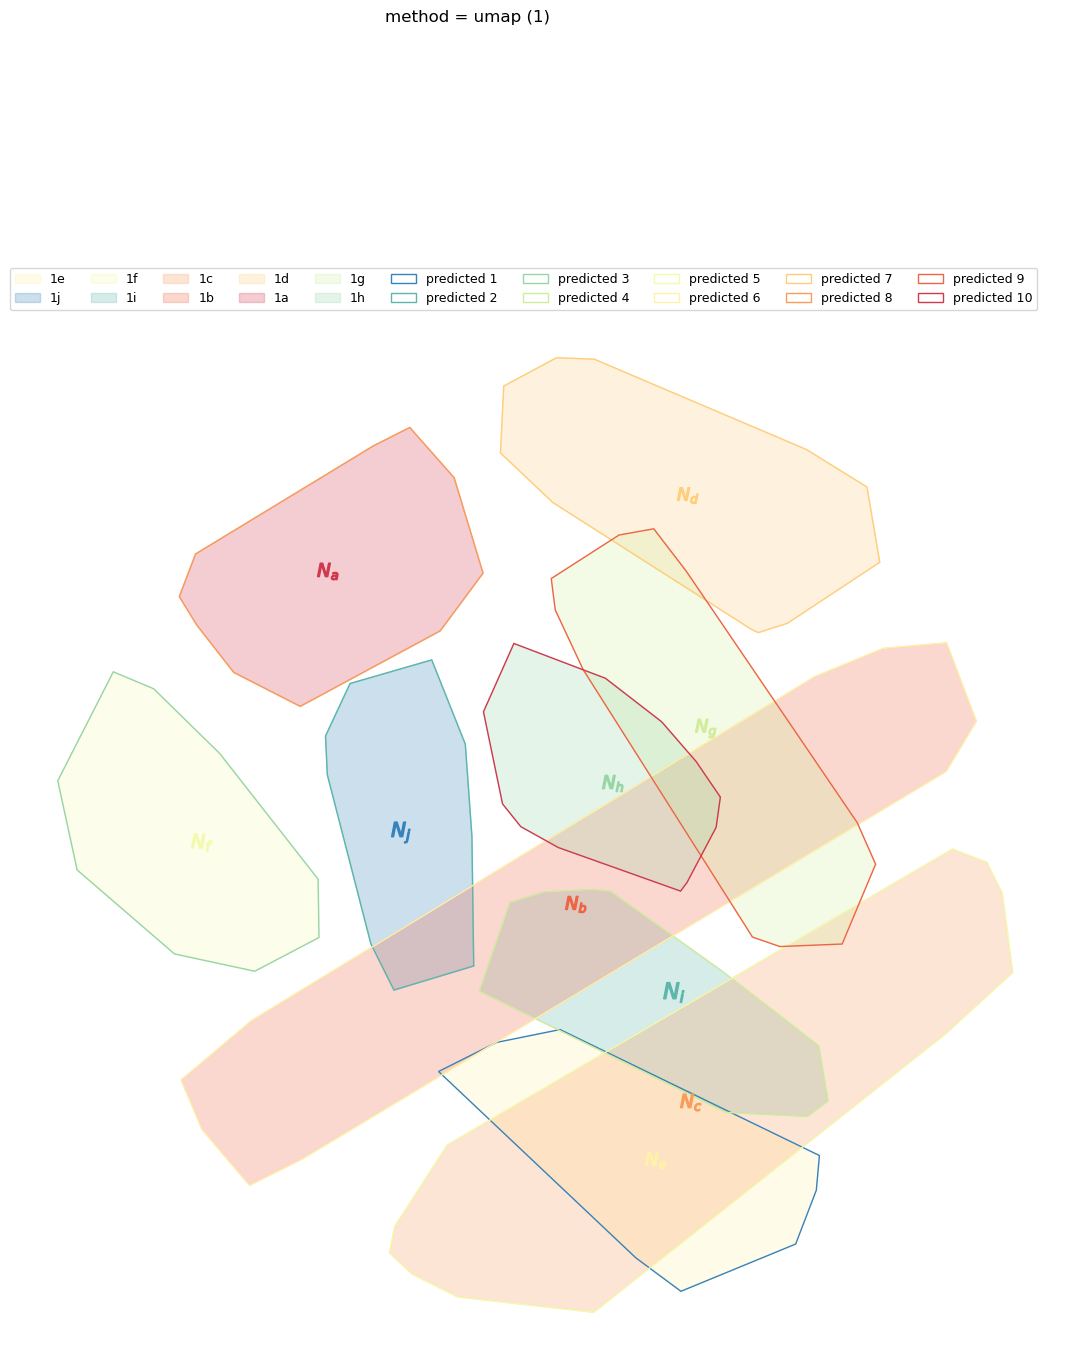

In [9]:
"""
2-Dimensional visualization of clusters (UMAP visualization) 
- all predicted classes 
- colored predicted classes or true classes 
"""
pdf= PdfPages("Figures/"+DataName+"_UMAP.pdf")
fig, ax = plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, min_dist = 0.8, 
          method = "umap", 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"],# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [(" ",5),(" ",5)], # optional markers list and their size for X and Y
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, #optional show the the axis lines going through embedded origin 
          legend = True, # add legend only if true cluster are required
          wrap_true = True, # wrapp the members of a true cluster , in each indentified clusters
          group_annot_size = 15, ### size of the annotations in the center of polygones‚
          wrap_predicted = True, # full lines to wrap around the predicted cluster
          show_pred_outliers = False, #
          def_pred_outliers = (3, 0.75), # (a, b), greater than a*std of pairwise dist for more than b*100% of the points in the predicted class
          oultiers_markers = ("P", "^", 5), # (true, predicted, size)
          wrap_type = "convexhull", # convexhull or ellipse (ellipse does not look accurate)
          dataname = "Corr") # true cluster markers for this simulation
import matplotlib.pyplot as plt
pdf.savefig(fig, bbox_inches = "tight")
pdf.close()
plt.legend(loc = (0,1), fontsize = 9, ncol = 10)
plt.show()

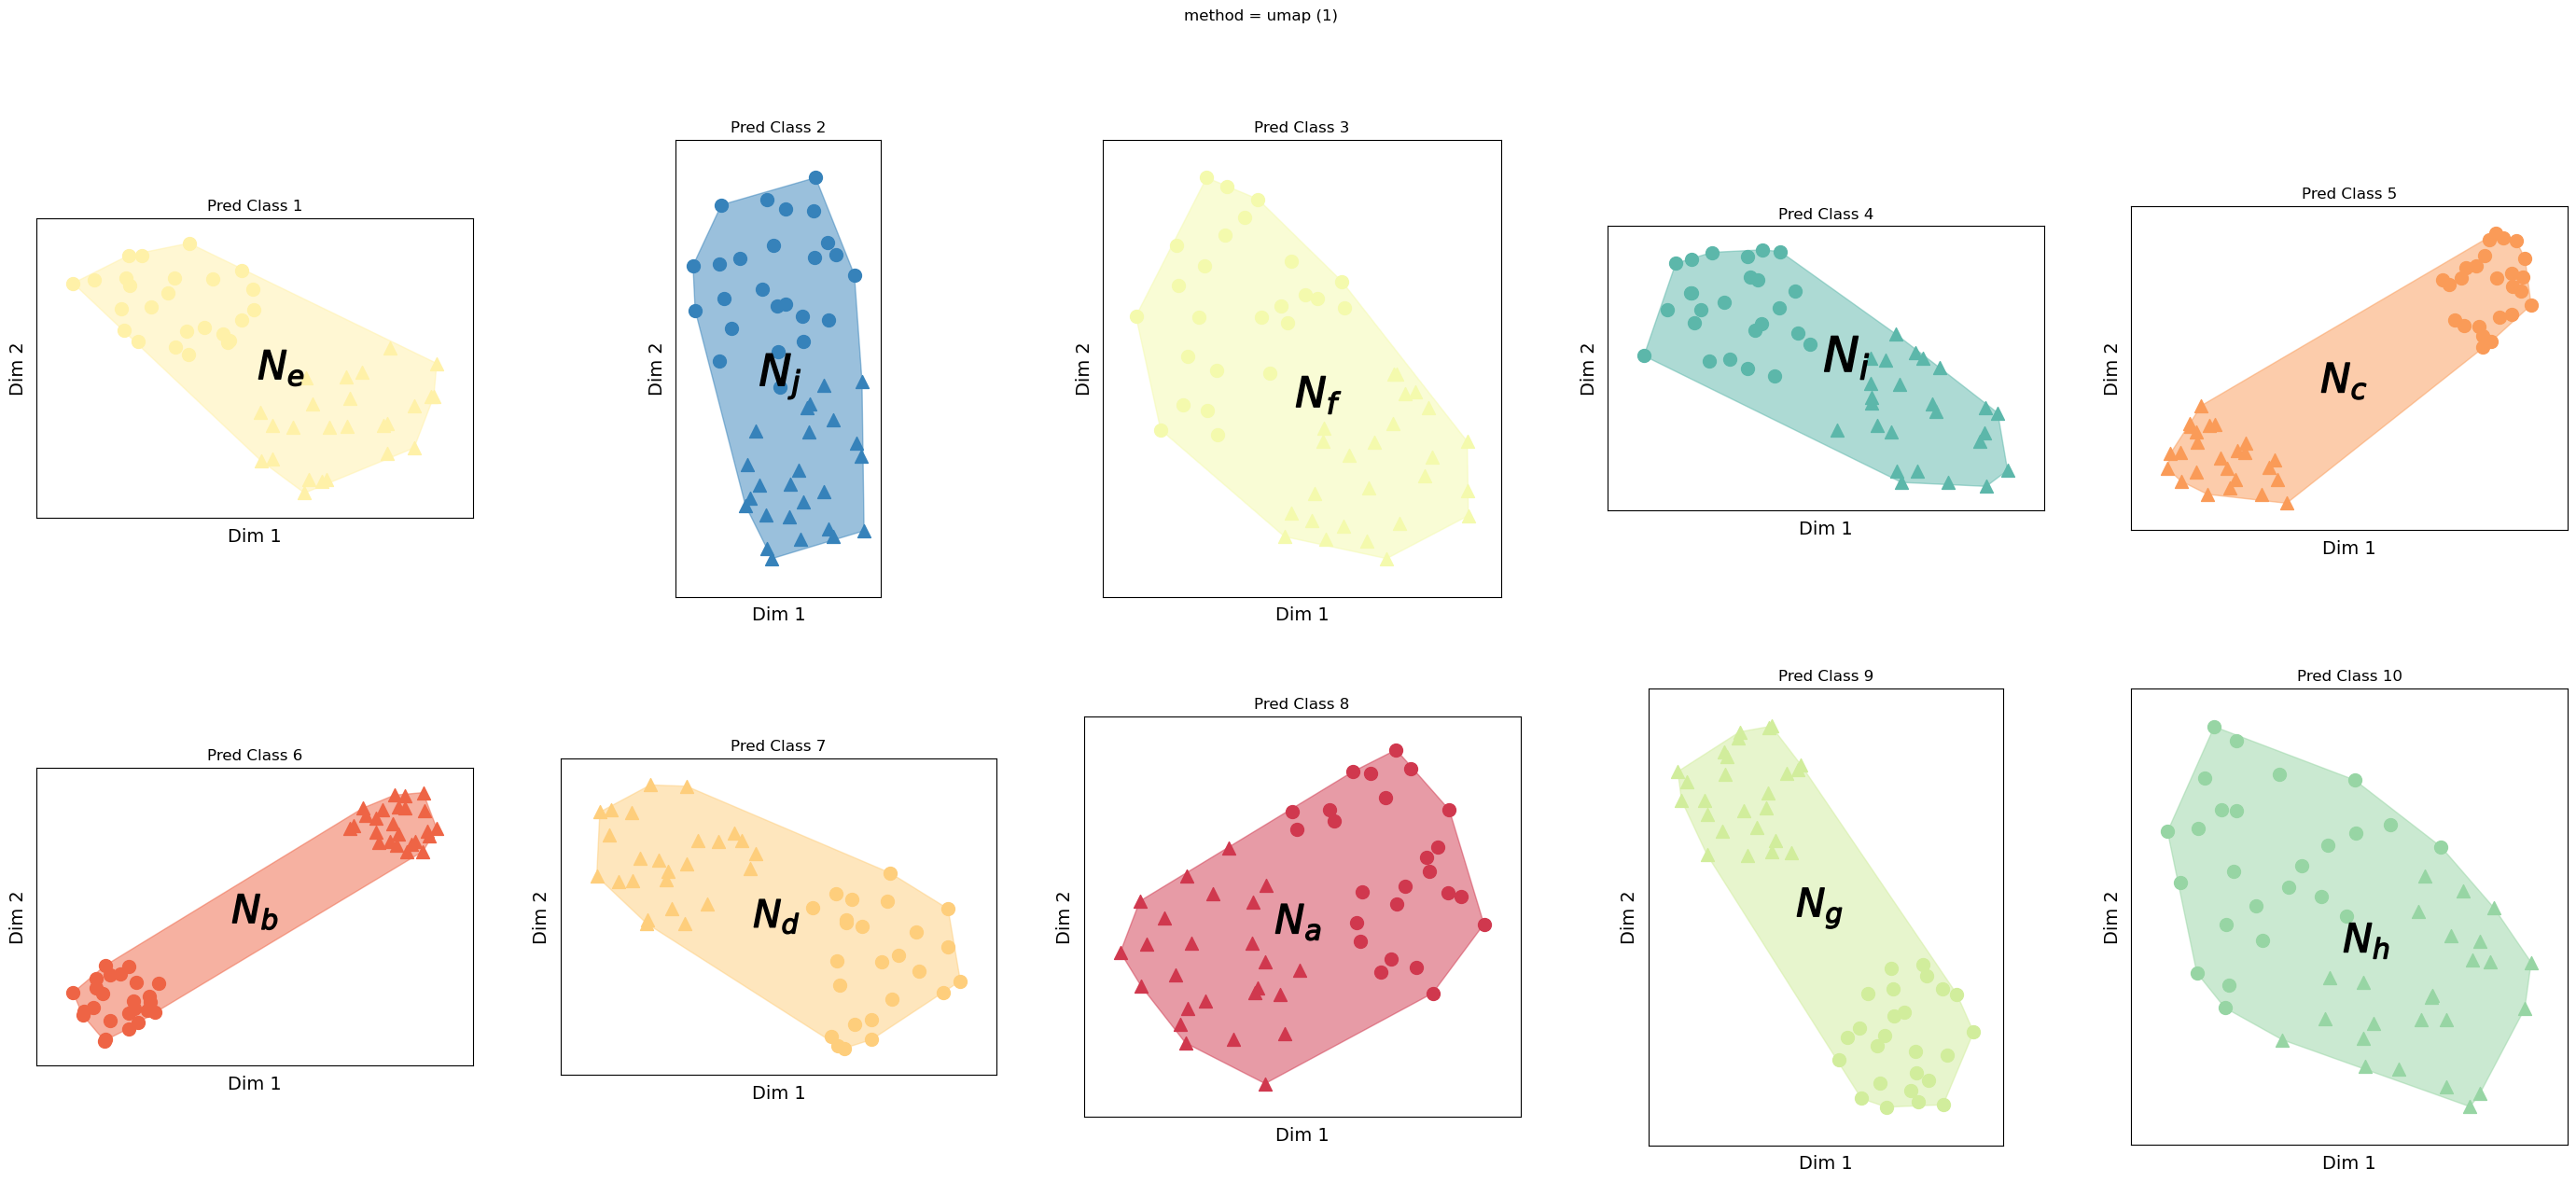

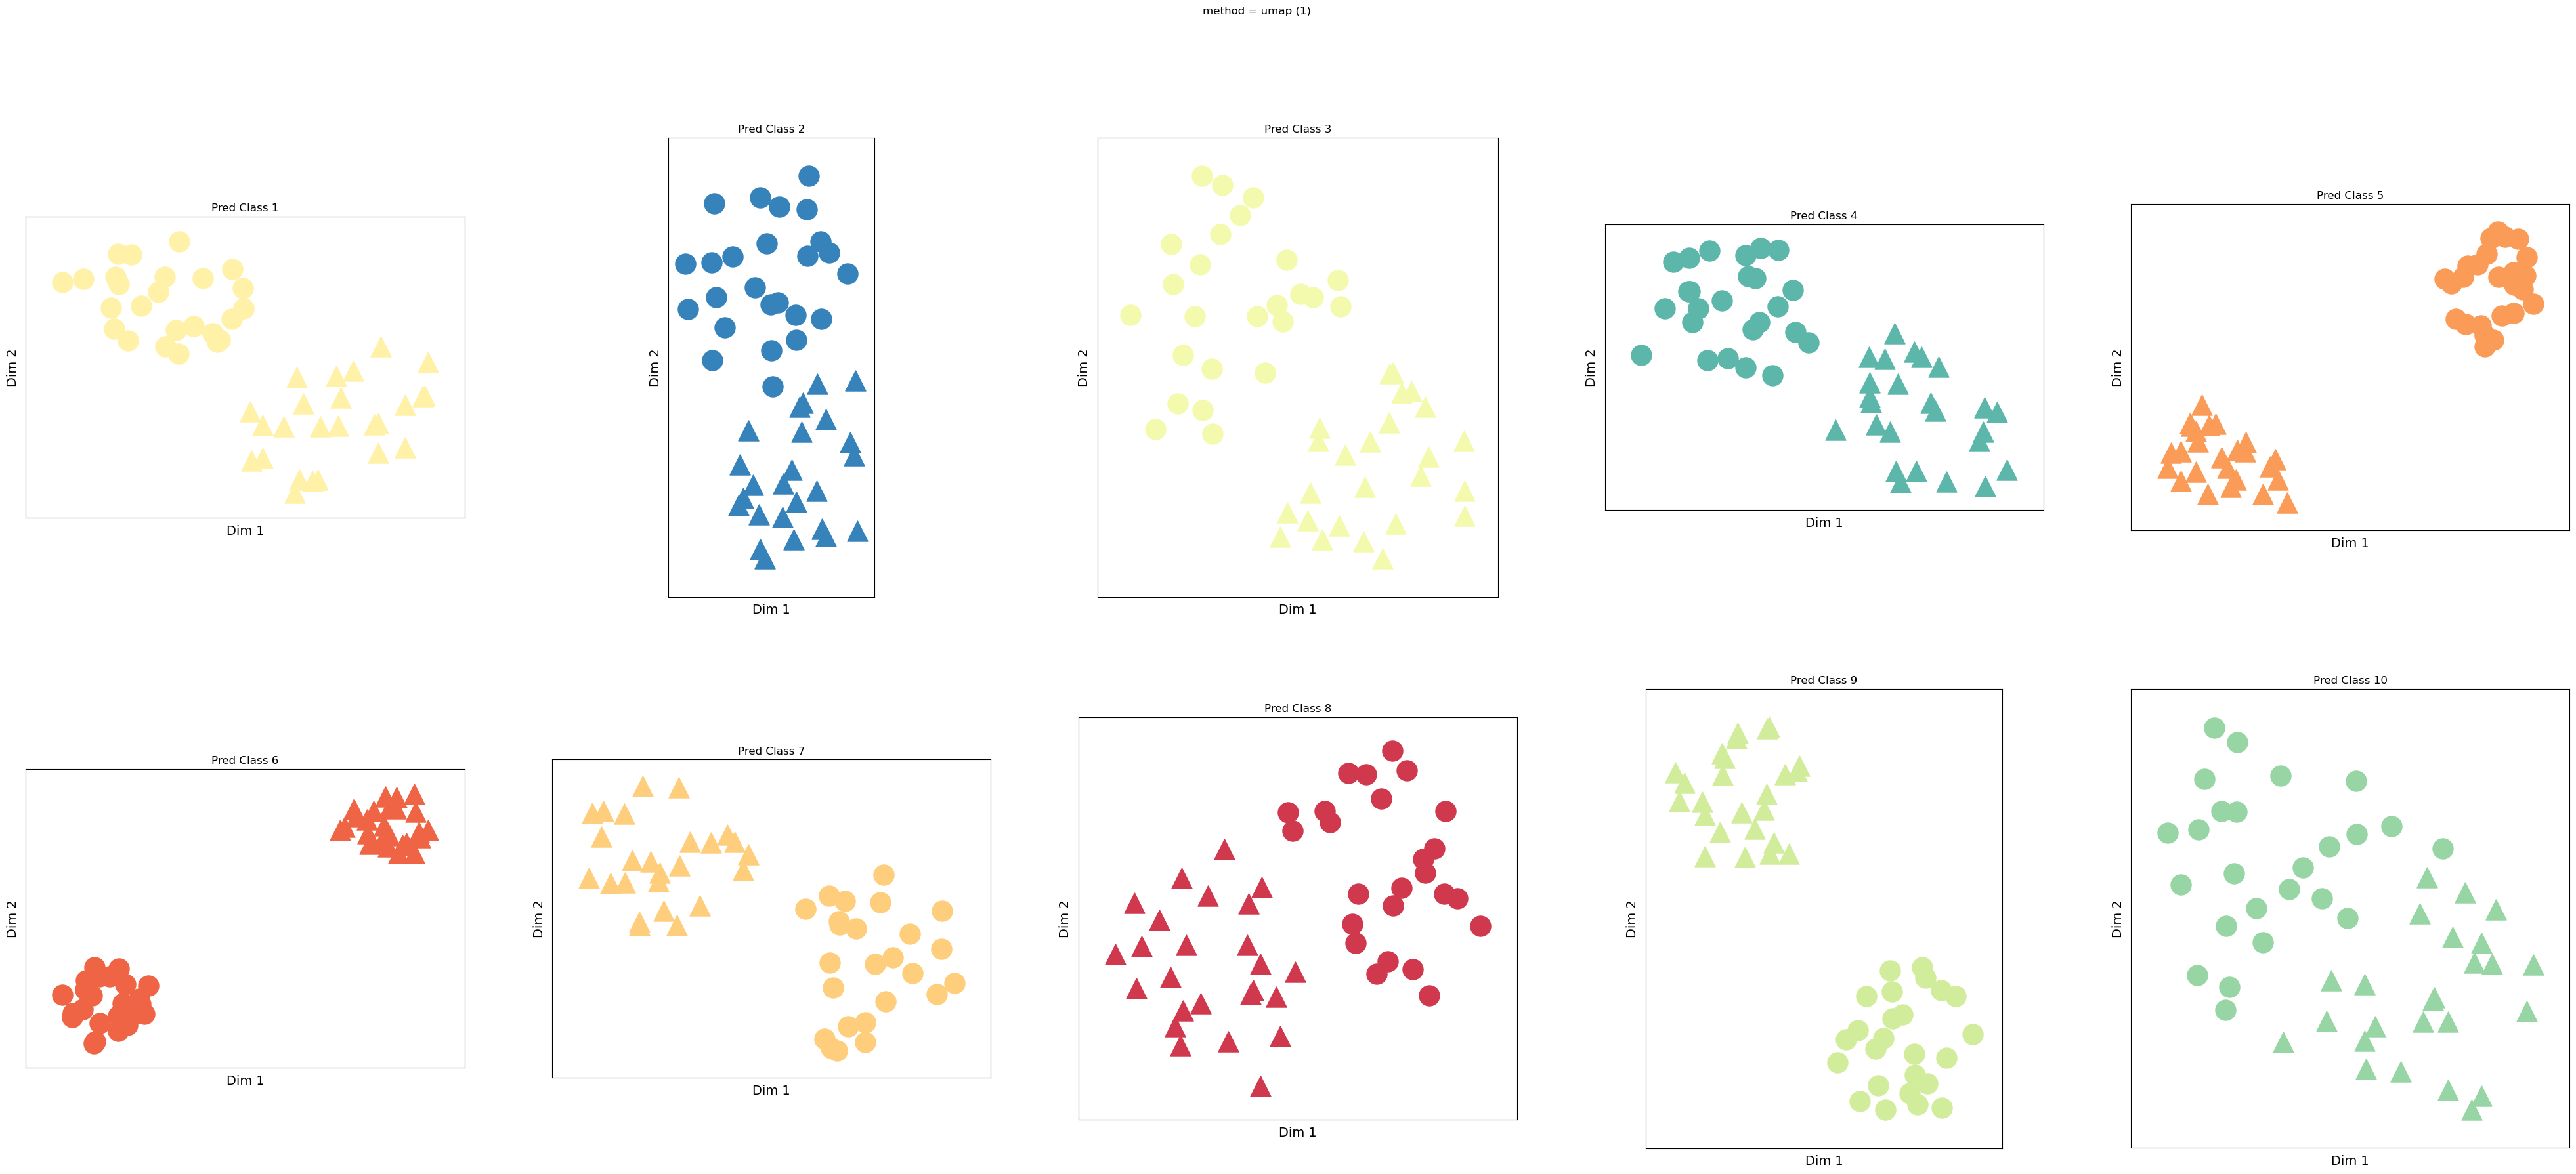

In [10]:
"""2-Dimensional visualization visualization of clusters (UMAP visualization) 
- separated predicted classes 
- wrapped true classes
"""
pdf2= PdfPages("Figures/Final/"+DataName+"_UMAP.pdf")
fig2, ax = plotClass_separated(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, min_dist = 0.8, 
          method = "umap", 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"],# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("^",100)], # optional markers list and their size for X and Y
          #markers_color = ("grey", "grey"),
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, #optional show the the axis lines going through embedded origin 
          legend = False, # add legend only if true cluster are required
          wrap_true = True, # wrapp the members of a true cluster , in each indentified clusters
          group_annot_size = 35, ### size of the annotations in the center of polygones‚
          group_color = "black", ### color of cluster annotatations (if None then true colors)
          wrap_predicted = False, # full lines to wrap around the predicted cluster (excluding some outliers)
          wrap_pred_params = ("black", 3), ### optional for pred wrap (color, linewidth)
          show_pred_outliers = False, 
          def_pred_outliers = (3, 0.75), # (a, b), greater than a*std of pairwise dist for more than b*100% of the points in the predicted class
          oultiers_markers = ("P", "^", 15), # (true, predicted, size)
          wrap_type = "convexhull", # convexhull or ellipse (ellipse does not look accurate)
          points_hull = 4, ## threshold for connecting points in convex hull
          dataname = "Corr",# true cluster markers for this simulation
          show_separation = True, ### show axis to clearly separate all predicted clusters
          num_row_col = (2, 5),
          alpha = 0.5) 

pdf2.savefig(fig2, bbox_inches = "tight")

"""2-Dimensional visualization visualization of clusters (UMAP visualization) 
- separated predicted classes 
- colored true classes
"""
fig, ax = plotClass_separated_ver0(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, min_dist = 0.8, 
          method = "umap",
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",500),("^",500)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin 
          show_separation = True, # optional separate all subfigs
          num_row_col = (2, 5),  # number of subfigs in row and col
          dataname = "Corr",# true cluster markers for this simulation
          ) 

pdf2.savefig(fig, bbox_inches = "tight")
pdf2.close()

In [11]:
"""Print average distances for each Predicted sample"""
unique_pred = np.unique(Id_Class["Class_pred"])
DMat = Id_Class["DMat"]
All_btw = DMat[:len(X_vars), -len(Y_vars):] - 1e-5
Spearman_abs = 1 - All_btw
Dist_x = DMat[:len(X_vars), :len(X_vars)]
Dist_y = DMat[-len(Y_vars):, -len(Y_vars):]
for i in range(len(unique_pred)):
    where_i = np.where(Id_Class["Class_pred"] == unique_pred[i])[0]
    where_x = where_i[where_i<len(X_vars)]
    where_y = where_i[where_i>=len(X_vars)] - len(X_vars)
    gridx0, gridx1 = np.meshgrid(where_x, where_x)
    gridy0, gridy1 = np.meshgrid(where_y, where_y)
    gridxy0, gridxy1 = np.meshgrid(where_x, where_y)
    
    rl_btw = (np.mean(All_btw[gridxy0, gridxy1])-np.mean(All_btw))/np.mean(All_btw)
    rl_x = (np.mean(Dist_x[gridx0, gridx1]) - np.mean(Dist_x))/np.mean(Dist_x)
    rl_y = (np.mean(Dist_y[gridy0, gridy1]) - np.mean(Dist_y))/np.mean(Dist_y)
    res = i+1, rl_btw, rl_x , rl_y     
    
    Spre = (np.mean(Spearman_abs[gridxy0, gridxy1])-np.mean(Spearman_abs))/np.mean(Spearman_abs)
    print("Pred Class %d relative: mean between = %.5f, mean X dist: %.5f, mean Y dist: %.5f"%res)
    print("Pred Class %d relative: mean Spearman_R magnitude:%.5f "%(i+1, Spre))
    print("")
         

Pred Class 1 relative: mean between = -0.00606, mean X dist: -0.95764, mean Y dist: -0.96261
Pred Class 1 relative: mean Spearman_R magnitude:0.12187 

Pred Class 2 relative: mean between = -0.01276, mean X dist: -0.96214, mean Y dist: -0.96196
Pred Class 2 relative: mean Spearman_R magnitude:0.25683 

Pred Class 3 relative: mean between = -0.01340, mean X dist: -0.95781, mean Y dist: -0.95755
Pred Class 3 relative: mean Spearman_R magnitude:0.26974 

Pred Class 4 relative: mean between = -0.00759, mean X dist: -0.95562, mean Y dist: -0.96378
Pred Class 4 relative: mean Spearman_R magnitude:0.15270 

Pred Class 5 relative: mean between = -0.00928, mean X dist: -0.95501, mean Y dist: -0.95933
Pred Class 5 relative: mean Spearman_R magnitude:0.18685 

Pred Class 6 relative: mean between = -0.01750, mean X dist: -0.95323, mean Y dist: -0.95994
Pred Class 6 relative: mean Spearman_R magnitude:0.35218 

Pred Class 7 relative: mean between = -0.00853, mean X dist: -0.94978, mean Y dist: -0.9

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


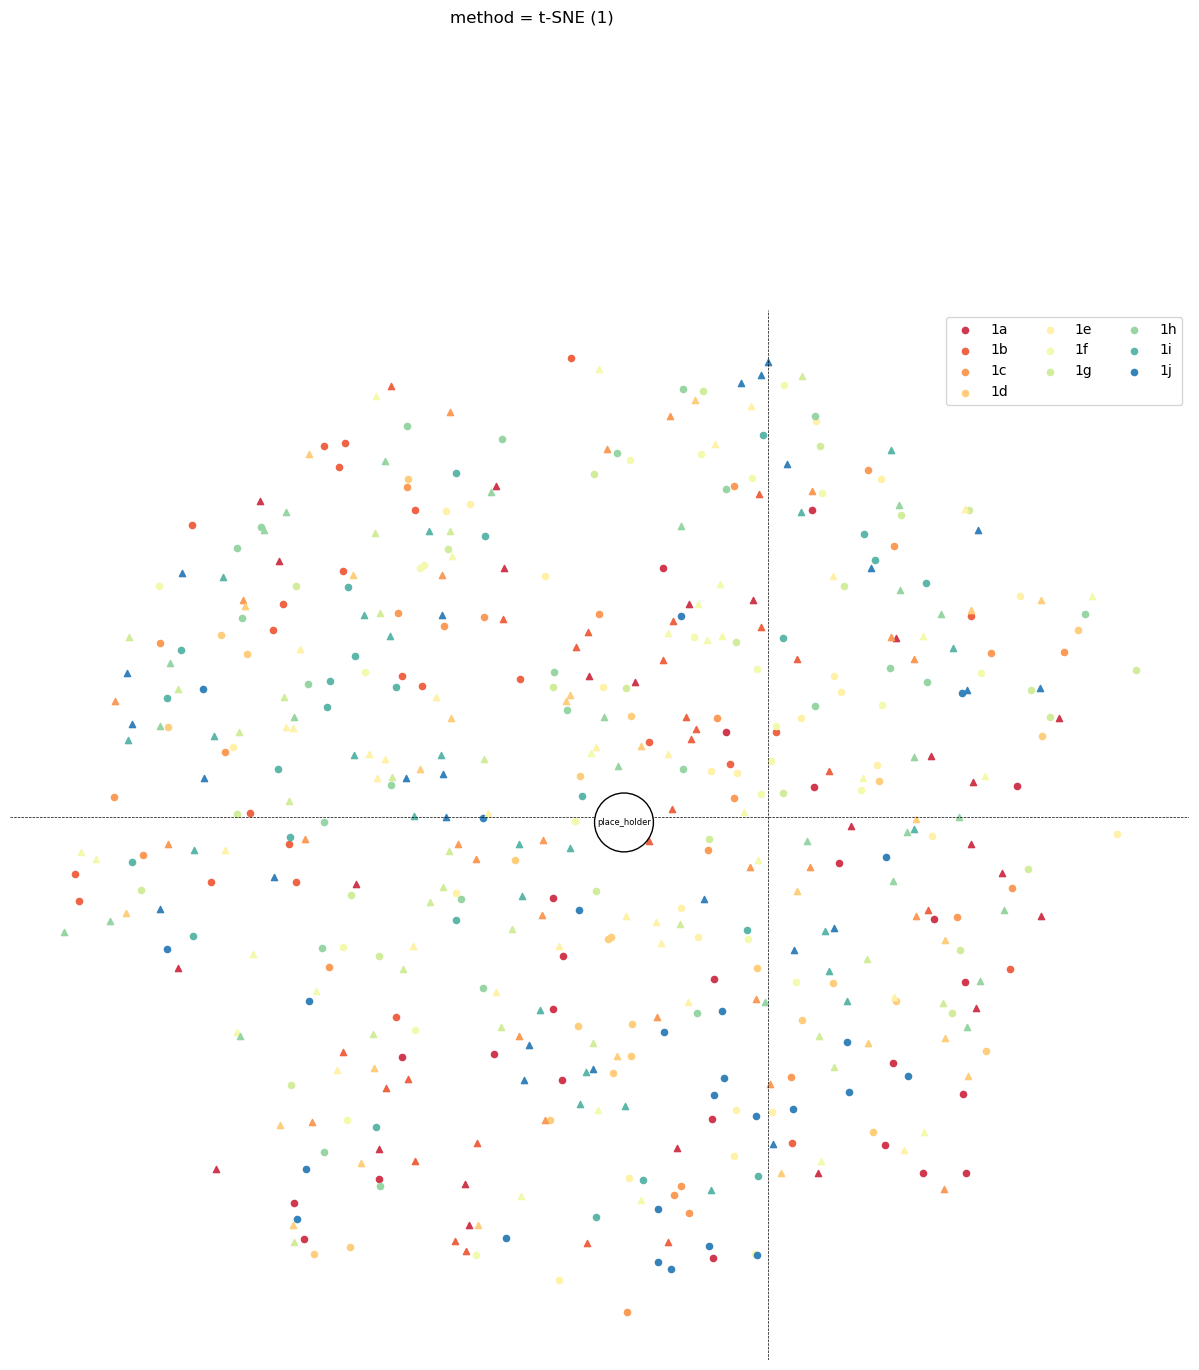

In [12]:
"""
2-Dimensional visualization of clusters (TSNE visualization) 
- all predicted classes 
- colored predicted classes 
"""
pdf= PdfPages("Figures/"+DataName+"_TSNE.pdf")
fig, ax = plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, 
          method = "t-SNE", scale = "pca", # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors =  False, # chosed_color: if False, true_colors bellow must be given 
          true_colors =  data_dic_orig["true_colors"],# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",20),("^",20)], # optional markers list and their size for X and Y
          show_labels = False, # optional show the labels of X and Y
          show_orig = True)# optional show the the axis lines going through origin 

pdf.savefig(fig, bbox_inches = "tight")
plt.show()

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


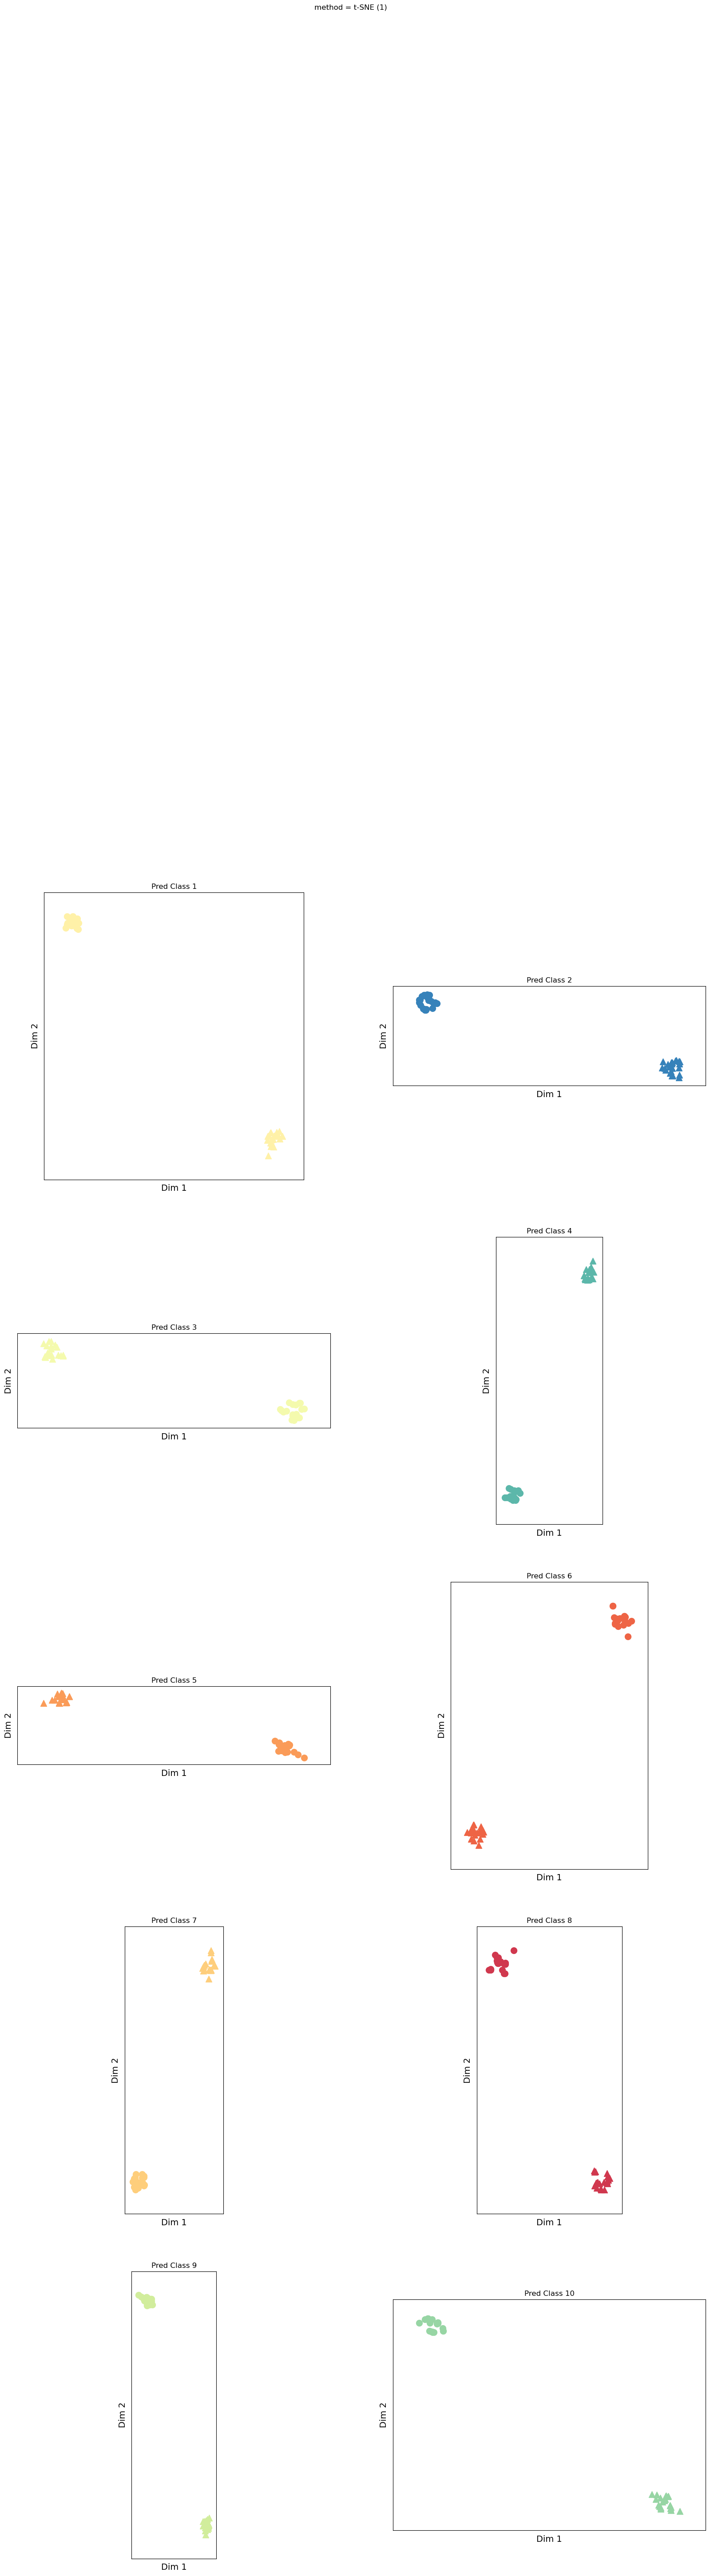

In [13]:
"""
2-Dimensional visualization of MIASA clusters (TSNE visualization) 
- separated predicted classes 
- colored true classes
"""
fig, ax = plotClass_separated_ver0(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, 
          method = "t-SNE", 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("^",100)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin
          show_separation = True, # optional separate all subfigs
          num_row_col = (20, 2) )  # number of subfigs in row and col

pdf.savefig(fig, bbox_inches = "tight")
pdf.close() # save everything                
plt.show()

------------- Evaluate clustering ------------
Rand Index 0.8748056112224449 
Adjusted Rand_Index 0.29771509518634465
ARI_HAx, ARI_HAy, ARI_HAxy 0.6446828061648877 0.4341377560385691 0.4538627134051547
mean(RIx, RIy, RIxy), mean(ARIy_HAx, ARIy_HAy, ARI_HAxy) (0.911460271430498, 0.5108944252028705)


/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


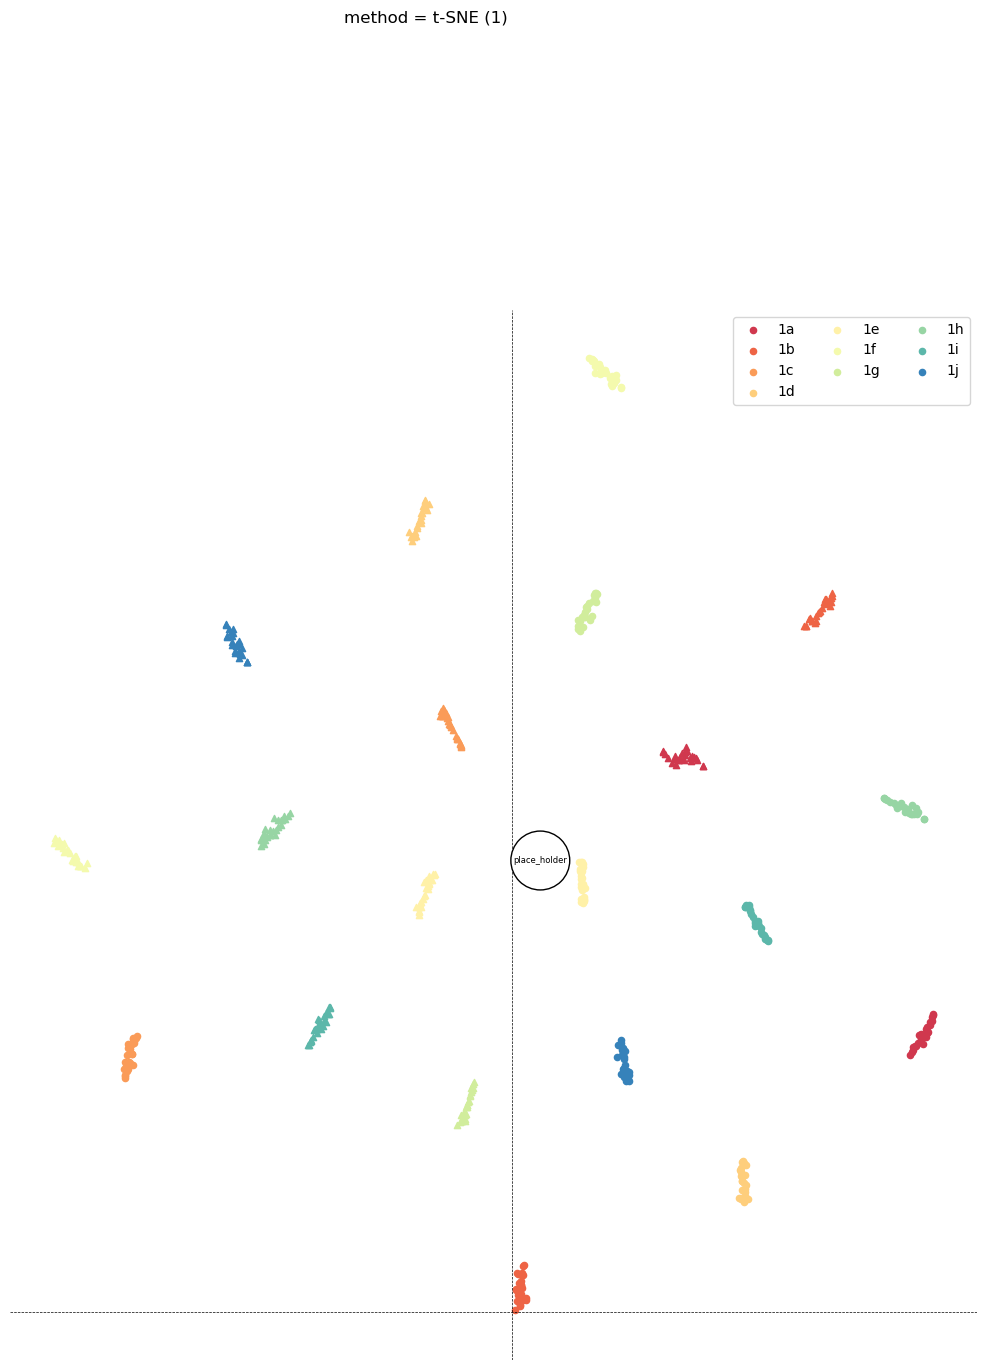

In [14]:
"""
Perform analogue non-metric: extract the classification, 
MDS methods based on the distance matrix can be used for visualization (e.g. sklearn.manifold.MDS or t-SNE). 
"""
from Methods.NonMD_class import NonMetric_Class
Id_Class_2 = NonMetric_Class(X, Y, num_clust, 
                       dist_origin = dist_origin,  # including distance to origin is the same as clustering over true feature norm
                       metric_method = metric_method, 
                       clust_method = "Kmedoids", # clustering is based on distance matrix including info in dist_origin (it is not Euclidean thus we can't use Kmeans)
                        Feature_dic = Feature_dic,
                       in_threads = in_threads,
                       palette = palette)

print("------------- Evaluate clustering ------------")
accuracy_2b = rand_score(Class_True, Id_Class_2["Class_pred"])
accuracy_3b = adjusted_rand_score(Class_True, Id_Class_2["Class_pred"])
print("Rand Index", accuracy_2b, "\nAdjusted Rand_Index", accuracy_3b)
"""ARI_HA: Hubert Arabie adjusted rand index --- Computed with original formula"""
print("mean(RIx, RIy, RIxy), mean(ARIy_HAx, ARIy_HAy, ARI_HAxy)", miasa_accuracy(Class_True, Id_Class_2["Class_pred"], X.shape[0], Y.shape[0], quiet = False))

"""
2-Dimensional visualization of clusters (MDS visualization) 
- all predicted classes 
- colored predicted classes 
"""
nonMD_low = "t-SNE"
pdf = PdfPages("Figures/"+DataName+"_NonMD_%s.pdf"%nonMD_low)
fig, ax = plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 15,
          method = nonMD_low, 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"],# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",20),("^",20)], # optional markers list and their size for X and Y
          show_labels = False, # optional show the labels of X and Y
          show_orig = True, # optional show the the axis lines going through origin  
          metric = "precomputed") # Necessary option for non-Metric, use Distance matrix

pdf.savefig(fig, bbox_inches = "tight")
pdf.close()
plt.show()